In [1]:
import numpy as np
from datetime import datetime
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results
# from apex import amp

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
# path_to_data = 'asbestos'
anno_lab_stone = parse_anno_file(os.path.join('annotations_stone_lab_camera.xml'))
anno_stone_161220 = parse_anno_file(os.path.join('annotations_stone_161220.xml'))
anno_tr_stones = parse_anno_file(os.path.join('asbestos', 'tr_stones', 'annotation', 'annotation.xml'))
anno_transporter = []
for an in anno_tr_stones:
    proba, _, date, *_ = an['name'].split('/')[-1].split('_')
    if int(proba) >= 10 and int(proba) <= 15 and datetime.strptime(date, '%d-%m-%Y').day == 16:
        anno_transporter.append(an)
        anno_transporter[-1]['name'] = os.path.join('asbestos', 'tr_stones', 'images', an['name'].split('/')[-1]) 
# transporter_file = os.path.join('asbest', 'transporter', '2020.03.16', 'TRANS_11:28:05_16-03-2020_36.png')
# plt.imshow(cv2.imread(transporter_file, cv2.IMREAD_UNCHANGED))
# print(len(anno_lab_stones), len(anno_stone_161220))

img_lab_stone = (int(anno_lab_stone[0]['height']), int(anno_lab_stone[0]['width']))
print('Размер кадра с одиночными камнями:')
print(img_lab_stone)
print(len(anno_lab_stone))
img_stone_161220 = (int(anno_stone_161220[0]['height']), int(anno_stone_161220[0]['width']))
print('Размер кадра с камнями в забое:')
print(img_stone_161220)
print(len(anno_stone_161220))
img_transporter = (int(anno_transporter[0]['height']), int(anno_transporter[0]['width']))
print('Размер кадра с камнями на транспортерной ленте:')
print(img_transporter)
print(len(anno_transporter))

Размер кадра с одиночными камнями:
(3456, 5184)
46
Размер кадра с камнями в забое:
(2048, 2592)
57
Размер кадра с камнями на транспортерной ленте:
(2048, 2592)
18


In [3]:
anno_stone = sum([anno_stone_161220, anno_lab_stone, anno_transporter],[])

In [4]:
# Деление на тренировочную и тестовую подвыборку одиночных камней
stone_valid_indexes = np.array([3, 7, 15, 30, 33, 42, 45], dtype=int)
stone_train_indexes = np.array(list(set(np.arange(len(anno_stone))) - set(stone_valid_indexes)), dtype=int)

In [5]:
img_sizes = [(1024, 1024)]#, (3*224, 3*224), (4*224, 4*224)]
crop_sizes = [(1024, 1024)]
num_frames = [(500, 50)] #, (400, 50), (400, 50)]
batches = [2]#, 4, 2]
num_epochs = [500]#, 100, 100]

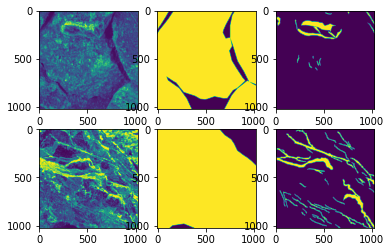

In [6]:
# Проверка картинок с одиночных камней
stone_train = Asbest_segmentation(np.array(anno_stone)[stone_train_indexes], 
                                  transporter_file=None, 
                                  crop_size=crop_sizes[0], 
                                  img_size=img_sizes[0],
#                                         random_crop=False,
                                  num_frames=200, 
                                  normalize=True)
stone_valid = Asbest_segmentation(np.array(anno_stone)[stone_valid_indexes], transporter_file=None, 
                                  crop_size=crop_sizes[0], 
                                  img_size=img_sizes[0],
                                  zoomed = None,
#                                         random_crop=False,
                                  num_frames=200, normalize=True)
index = 100
img, msk_st, msk_asb = stone_train[index]
plt.subplot(231)
plt.imshow(np.squeeze(img))
plt.subplot(232)
plt.imshow(np.squeeze(msk_st))
plt.subplot(233)
plt.imshow(np.squeeze(msk_asb))
img, msk_st, msk_asb = stone_valid[index]
plt.subplot(234)
plt.imshow(np.squeeze(img))
plt.subplot(235)
plt.imshow(np.squeeze(msk_st))
plt.subplot(236)
plt.imshow(np.squeeze(msk_asb))

In [7]:
# imp_anno_tr_stones = []
# for it in anno_tr_stones:
#     name = it['name'].split('/')[-1]
# #     if get_time(name).day != 16:
# #         continue
#     probe = int(name.split('_')[0])
#     if probe < 10 or probe > 14:
#         continue
#     imp_anno_tr_stones.append(it)

In [8]:
# Проверка картинок с транспортеной ленты

# tr_stones_train_data = Asbest_segmentation(imp_anno_tr_stones[:-5], 
#                                            crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
#                                            random_crop=True,
#                                            img_size=(448, 448), 
#                                            num_frames=10,
#                                            zoomed = (0.1, 0.2),
#                                            normalize=True)
# tr_stones_valid_data = Asbest_segmentation(imp_anno_tr_stones[-5:], 
#                                            crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
#                                            random_crop=True,
#                                            img_size=(448, 448), 
#                                            num_frames=10, 
#                                            zoomed = (0.1, 0.2),
#                                            normalize=True)
# index = 4
# img, msk_st, msk_asb = tr_stones_train_data[index]
# plt.subplot(231)
# plt.imshow(np.squeeze(img))
# plt.subplot(232)
# plt.imshow(np.squeeze(msk_st))
# plt.subplot(233)
# plt.imshow(np.squeeze(msk_asb))
# img, msk_st, msk_asb = tr_stones_valid_data[index]
# plt.subplot(234)
# plt.imshow(np.squeeze(img))
# plt.subplot(235)
# plt.imshow(np.squeeze(msk_st))
# plt.subplot(236)
# plt.imshow(np.squeeze(msk_asb))

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [10]:
from torch import nn
from torch import sigmoid
import segmentation_models_pytorch as smp


device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

model = smp.Unet(encoder_name='efficientnet-b3', encoder_weights='imagenet', in_channels=1, classes=2,  activation='sigmoid').to(device) #encoder_weights='imagenet',
# model.load_state_dict(torch.load('asbest_segmentation_b3_v1.2.pth'))

# weight = 10 * torch.ones((1,1,512,512), device=device).to(device)
weight = 20 * torch.ones((1,1,1024,1024), device=device).to(device)
criterion = smp.utils.losses.BCEWithLogitsLoss(pos_weight=weight)
# dice = smp.utils.losses.DiceLoss()
# criterion = nn.CrossEntropyLoss()
# criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc


metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-5, 'betas': (0.99, 0.99)}, 

    {'params': model.encoder.parameters(), 'lr': 1e-5, 'betas': (0.99, 0.99)},  
])

In [11]:
# model, optimizer = amp.initialize(model, 
#                                   optimizer, 
#                                   opt_level='O1')
# model = model.to(device)

In [12]:
def save_fig(crop_size, inp_size):
    files = ['asbestos/stones/161220/ManualGeneralImage_10_01_26.bmp',
             'asbestos/stones/161220/ManualDetailedImage_11_04_07.bmp',
             'asbestos/stones/161220/ManualDetailedImage_10_10_10.bmp',
             'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-37_3_1_detailed.bmp',             
            ]

    full_image = None
    for i, file in enumerate(files):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        image, st_mask, asb_mask = big_image_predict(model, img, crop_size=crop_size, inp_size=inp_size, device=device)
        if full_image is None:
            full_image = np.concatenate((image, st_mask, asb_mask), axis=0)
        else:
            full_image = np.concatenate((full_image, np.concatenate((image, st_mask, asb_mask), axis=0)), axis=1)
    cv2.imwrite('graphics/' + datetime.now().strftime("%H:%M:%S") + '_segm_images.png', cv2.resize((full_image * 255).astype(np.uint8), (int(full_image.shape[1] / 8), int(full_image.shape[0] / 8))))
#     return full_image


0:00:01.640615


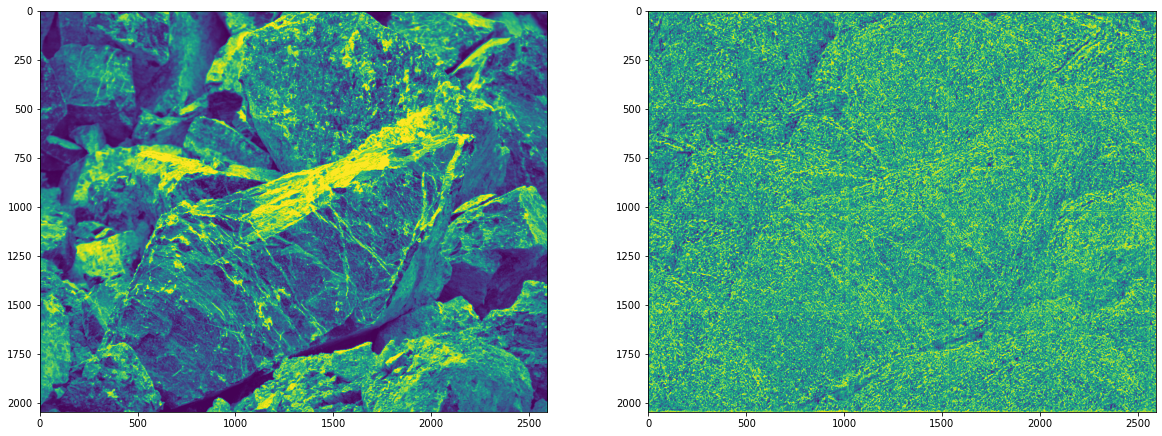

In [13]:
from datetime import datetime
img = cv2.imread('asbestos/stones/161220/ManualGeneralImage_10_01_26.bmp', cv2.IMREAD_UNCHANGED)
cur_time = datetime.now()
img, st, asb = big_image_predict(model, 
                                  img, 
                                  crop_size=(2*512,2*512),#(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
                                  inp_size=(2*512,2*512),
                                  device=device
                                 )
print(datetime.now() - cur_time)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(asb)

# plt.subplot(131)
# plt.imshow(img)
# plt.subplot(132)
# plt.imshow(st)
# plt.subplot(133)
# plt.imshow(asb)

In [14]:
# cv2.imwrite('graphics/frame.png', 255*img)
# cv2.imwrite('graphics/mask.png', 255*asb)

In [15]:
from tqdm import trange, tqdm
from torch.utils.data import DataLoader

# model.load_state_dict(torch.load('asbest_segmentation_b0_v1.0.pth'))
# anno_stone = sum([anno_stone_161220],[])
# stone_valid_indexes = np.array([3, 7, 15, 30, 33, 42, 45], dtype=int)
# stone_train_indexes = np.array(list(set(np.arange(len(anno_stone))) - set(stone_valid_indexes)), dtype=int)

img_sizes = [
#     (1*128, 1*128), 
#     (2*128, 2*128), 
#     (4*128, 4*128)
    (2*512, 2*512)
]

crop_sizes = [
#     (4*256, 4*256),
#     (4*256, 4*256),
#     (4*256, 4*256),
    (2*512, 2*512)
]

num_frames = [
#     ((5 * len(np.array(anno_stones)[stones_train_indexes]), 5 * len(np.array(anno_stones)[stones_valid_indexes]))),
#     ((5 * len(np.array(anno_stones)[stones_train_indexes]), 5 * len(np.array(anno_stones)[stones_valid_indexes]))),
    ((3 * len(np.array(anno_stone)[stone_train_indexes]), 3 * len(np.array(anno_stone)[stone_valid_indexes]))),
]

batches = [2]#[16, 4, 2,]#, 4, 2]
num_epochs = [150]#[50,50,50]#, 100, 100]

segm_asbest_dict = {'loss':[], 'val_loss':[], 'asb_iou':[], 'val_asb_iou':[], 'asb_dice':[], 'val_asb_dice':[]}

for epochs, batch, crop_size, img_size, num_frame in zip(num_epochs, batches, crop_sizes, img_sizes, num_frames):

    stones_train_data = Asbest_segmentation(np.array(anno_stone)[stone_train_indexes], 
#                                             transporter_file=transporter_file, 
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = True,
                                            zoomed=(0.8, 1.2),
                                            num_frames=num_frame[0], 
                                            normalize=True
                                           )

    stones_valid_data = Asbest_segmentation(np.array(anno_stone)[stone_valid_indexes], 
#                                             transporter_file=transporter_file, 
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = True,
                                            zoomed=(0.8, 1.2),
                                            num_frames=num_frame[1], 
                                            normalize=True
                                           )
    
    stones_train_loader = DataLoader(stones_train_data, batch_size=batch, shuffle=True, num_workers=4)
    stones_valid_loader = DataLoader(stones_valid_data, batch_size=1, shuffle=False, num_workers=2)
    
#     tr_stones_train_data = Asbest_segmentation(anno_tr_stones[:-30], 
#                                                crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
#                                                img_size=img_size, 
#                                                num_frames=100, 
#                                                normalize=True)
#     tr_stones_valid_data = Asbest_segmentation(anno_tr_stones[-30:], 
#                                                crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), 
#                                                img_size=img_size, 
#                                                num_frames=30, 
#                                                normalize=True)

#     tr_stones_train_loader = DataLoader(tr_stones_train_data, batch_size=2, shuffle=True, num_workers=4)
#     tr_stones_valid_loader = DataLoader(tr_stones_valid_data, batch_size=2, shuffle=False, num_workers=2)
    
    with tqdm(total=len(stones_train_loader) + len(stones_valid_loader),# + len(tr_stones_train_loader) + len(tr_stones_valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' +  
              '| iou_asb: {postfix[2]:>2.4f} ' + 
              '| dice_asb: {postfix[3]:>2.4f} ' + 
              '| val_loss : {postfix[4]:>2.4f} ' + 
              '| val_iou_asb: {postfix[5]:>2.4f} ' + 
              '| val_dice_asb: {postfix[6]:>2.4f} '
              , 
              postfix=[0, 0, 0, 0, 0, 0, 0], desc = 'Training', leave=True) as t:
        for epoch in range(1, epochs+1):
            
            t.postfix[0] = epoch
            
            average_total_loss = AverageMeter()
            average_iou_asbest = AverageMeter()
            average_dice_asbest = AverageMeter()

            model.train()
            for data in stones_train_loader:

#                 torch.cuda.empty_cache()
                inputs, st_masks, asb_masks = data
                masks = torch.cat((st_masks, asb_masks), axis=1)

                inputs=inputs.to(device).float()
                masks=masks.to(device).float()

                optimizer.zero_grad()
                outputs = model(inputs)

                loss = criterion(outputs[:,1:,:,:], masks[:,1:,:,:])# + 0.5 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])

                iou_asbest = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
                dice_asbest = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])

#                 with amp.scale_loss(loss, optimizer) as scaled_loss:
#                     scaled_loss.backward()
                loss.backward()
                optimizer.step()

                average_total_loss.update(loss.data.item())
                average_iou_asbest.update(iou_asbest.data.item())
                average_dice_asbest.update(dice_asbest.data.item())

                t.postfix[1] = average_total_loss.average()
                t.postfix[2] = average_iou_asbest.average()
                t.postfix[3] = average_dice_asbest.average()
                t.update()
            
        
            ## Validation          
            val_average_total_loss = AverageMeter()
            val_average_iou_asbest = AverageMeter()
            val_average_dice_asbest = AverageMeter()



            model.eval()
#             torch.cuda.empty_cache()
            for data in stones_valid_loader:

                inputs, st_masks, asb_masks = data
                masks = torch.cat((st_masks, asb_masks), axis=1)

                inputs=inputs.to(device).float()
                masks=masks.to(device).float()

                outputs = model(inputs)

                loss = criterion(outputs[:,1:,:,:], masks[:,1:,:,:])# + 0.5 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])

                iou_asbest = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
                dice_asbest = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])

                val_average_total_loss.update(loss.data.item())
                val_average_iou_asbest.update(iou_asbest.data.item())
                val_average_dice_asbest.update(dice_asbest.data.item())

                t.postfix[4] = val_average_total_loss.average()
                t.postfix[5] = val_average_iou_asbest.average()
                t.postfix[6] = val_average_dice_asbest.average()
                t.update()
    
            segm_asbest_dict['loss'].append(average_total_loss.average())
            segm_asbest_dict['val_loss'].append(val_average_total_loss.average())
            segm_asbest_dict['asb_iou'].append(average_iou_asbest.average())
            segm_asbest_dict['val_asb_iou'].append(val_average_iou_asbest.average())
            segm_asbest_dict['asb_dice'].append(average_dice_asbest.average())
            segm_asbest_dict['val_asb_dice'].append(val_average_dice_asbest.average())
            
            if epoch % 10 == 0:
                save_fig(crop_size=crop_size, inp_size=img_size) #
            t.reset()

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'asbest_segmentation_b3_v2.pth')

In [19]:
model.load_state_dict(torch.load('asbest_segmentation_b3_v2.pth'))
img_sizes = [
#     (1*128, 1*128), 
#     (2*128, 2*128), 
#     (4*128, 4*128)
    (2*512, 2*512)
]

crop_sizes = [
#     (4*256, 4*256),
#     (4*256, 4*256),
#     (4*256, 4*256),
    (2*512, 2*512)
]

num_frames = [
#     ((5 * len(np.array(anno_stones)[stones_train_indexes]), 5 * len(np.array(anno_stones)[stones_valid_indexes]))),
#     ((5 * len(np.array(anno_stones)[stones_train_indexes]), 5 * len(np.array(anno_stones)[stones_valid_indexes]))),
    ((3 * len(np.array(anno_stone)[stone_train_indexes]), 3 * len(np.array(anno_stone)[stone_valid_indexes]))),
]

batches = [2]#[16, 4, 2,]#, 4, 2]
num_epochs = [150]#[50,50,50]#, 100, 100]

eval_segm_asbest_dict = {'train_loss':[], 'val_loss':[], 'train_asb_iou':[], 'val_asb_iou':[], 'train_asb_dice':[], 'val_asb_dice':[]}

model.eval()
for epochs, batch, crop_size, img_size, num_frame in zip(num_epochs, batches, crop_sizes, img_sizes, num_frames):

    stones_train_data = Asbest_segmentation(np.array(anno_stone)[stone_train_indexes], 
#                                             transporter_file=transporter_file, 
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = True,
                                            zoomed=(0.8, 1.2),
                                            num_frames=num_frame[0], 
                                            normalize=True
                                           )

    stones_valid_data = Asbest_segmentation(np.array(anno_stone)[stone_valid_indexes], 
#                                             transporter_file=transporter_file, 
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = True,
                                            zoomed=(0.8, 1.2),
                                            num_frames=num_frame[1], 
                                            normalize=True
                                           )
    
    stones_train_loader = DataLoader(stones_train_data, batch_size=1, shuffle=True, num_workers=4)
    stones_valid_loader = DataLoader(stones_valid_data, batch_size=1, shuffle=False, num_workers=2)
    
#     tr_stones_train_data = Asbest_segmentation(anno_tr_stones[:-30], 
#                                                crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
#                                                img_size=img_size, 
#                                                num_frames=100, 
#                                                normalize=True)
#     tr_stones_valid_data = Asbest_segmentation(anno_tr_stones[-30:], 
#                                                crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), 
#                                                img_size=img_size, 
#                                                num_frames=30, 
#                                                normalize=True)

#     tr_stones_train_loader = DataLoader(tr_stones_train_data, batch_size=2, shuffle=True, num_workers=4)
#     tr_stones_valid_loader = DataLoader(tr_stones_valid_data, batch_size=2, shuffle=False, num_workers=2)
    
    with tqdm(total=len(stones_train_loader) + len(stones_valid_loader),# + len(tr_stones_train_loader) + len(tr_stones_valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' +  
              '| iou_asb: {postfix[2]:>2.4f} ' + 
              '| dice_asb: {postfix[3]:>2.4f} ' + 
              '| val_loss : {postfix[4]:>2.4f} ' + 
              '| val_iou_asb: {postfix[5]:>2.4f} ' + 
              '| val_dice_asb: {postfix[6]:>2.4f} '
              , 
              postfix=[0, 0, 0, 0, 0, 0, 0], desc = 'Training', leave=True) as t:


        for data in stones_train_loader:

#                 torch.cuda.empty_cache()
            inputs, st_masks, asb_masks = data
            masks = torch.cat((st_masks, asb_masks), axis=1)

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

#             optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs[:,1:,:,:], masks[:,1:,:,:])# + 0.5 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])

            iou_asbest = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
            dice_asbest = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])

#                 with amp.scale_loss(loss, optimizer) as scaled_loss:
#                     scaled_loss.backward()
#             loss.backward()
#             optimizer.step()

            eval_segm_asbest_dict['train_loss'].append(loss.data.item())
            eval_segm_asbest_dict['train_asb_dice'].append(dice_asbest.data.item())
            eval_segm_asbest_dict['train_asb_iou'].append(iou_asbest.data.item())

#             average_total_loss.update(loss.data.item())
#             average_iou_asbest.update(iou_asbest.data.item())
#             average_dice_asbest.update(dice_asbest.data.item())

#             t.postfix[1] = average_total_loss.average()
#             t.postfix[2] = average_iou_asbest.average()
#             t.postfix[3] = average_dice_asbest.average()
            t.update()


        ## Validation          
        val_average_total_loss = AverageMeter()
        val_average_iou_asbest = AverageMeter()
        val_average_dice_asbest = AverageMeter()



#             torch.cuda.empty_cache()
        for data in stones_valid_loader:

            inputs, st_masks, asb_masks = data
            masks = torch.cat((st_masks, asb_masks), axis=1)

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            outputs = model(inputs)

            loss = criterion(outputs[:,1:,:,:], masks[:,1:,:,:])# + 0.5 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])

            iou_asbest = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
            dice_asbest = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])
            
            eval_segm_asbest_dict['val_loss'].append(loss.data.item())
            eval_segm_asbest_dict['val_asb_dice'].append(dice_asbest.data.item())
            eval_segm_asbest_dict['val_asb_iou'].append(iou_asbest.data.item())

#             val_average_total_loss.update(loss.data.item())
#             val_average_iou_asbest.update(iou_asbest.data.item())
#             val_average_dice_asbest.update(dice_asbest.data.item())

#             t.postfix[4] = val_average_total_loss.average()
#             t.postfix[5] = val_average_iou_asbest.average()
#             t.postfix[6] = val_average_dice_asbest.average()
            t.update()

#         segm_asbest_dict['loss'].append(average_total_loss.average())
#         segm_asbest_dict['val_loss'].append(val_average_total_loss.average())
#         segm_asbest_dict['asb_iou'].append(average_iou_asbest.average())
#         segm_asbest_dict['val_asb_iou'].append(val_average_iou_asbest.average())
#         segm_asbest_dict['asb_dice'].append(average_dice_asbest.average())
#         segm_asbest_dict['val_asb_dice'].append(val_average_dice_asbest.average())

Training epoch 0 | 0/363 00:35<? | loss : 0.0000 | iou_asb: 0.0000 | dice_asb: 0.0000 | val_loss : 0.0000 | val_iou_asb: 0.0000 | val_dice_asb: 0.0000 


In [33]:
print('train dice: %.3f +- %.3f' % (np.mean(eval_segm_asbest_dict['train_asb_dice']), np.std(eval_segm_asbest_dict['train_asb_dice'])))
print('train iou: %.3f +- %.3f' % (np.mean(eval_segm_asbest_dict['train_asb_iou']), np.std(eval_segm_asbest_dict['train_asb_iou'])))

print('valid dice: %.3f +- %.3f' % (np.mean(eval_segm_asbest_dict['val_asb_dice']), np.std(eval_segm_asbest_dict['val_asb_dice'])))
print('valid iou: %.3f +- %.3f' % (np.mean(eval_segm_asbest_dict['val_asb_iou']), np.std(eval_segm_asbest_dict['val_asb_iou'])))

train dice: 0.540 +- 0.296
train iou: 0.422 +- 0.253
valid dice: 0.406 +- 0.169
valid iou: 0.268 +- 0.131


In [24]:
print(np.mean(eval_segm_asbest_dict['val_asb_dice']), np.std(eval_segm_asbest_dict['val_asb_dice']))

0.40561583603266627 0.16856268101209962


In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
# plt.title('loss (BCE)')
plt.plot(segm_asbest_dict['loss'], label='train_loss')
plt.plot(segm_asbest_dict['val_loss'], label='valid_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid('on')
plt.subplot(132)
# plt.title('Jaccard')
plt.plot(segm_asbest_dict['asb_iou'], label='train_jaccard')
plt.plot(segm_asbest_dict['val_asb_iou'], label='valid_jaccard')
plt.ylabel('jaccard')
plt.xlabel('epoch')
plt.legend()
plt.grid('on')
plt.subplot(133)
# plt.title('Dice')
plt.plot(segm_asbest_dict['asb_dice'], label='train_dice')
plt.plot(segm_asbest_dict['val_asb_dice'], label='valid_dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend()
plt.grid('on')

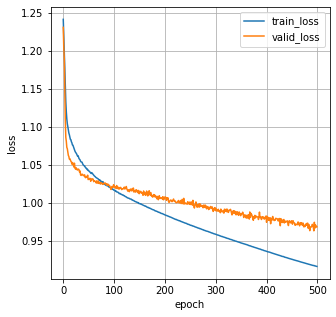

In [21]:
plt.figure(figsize=(5,5))
plt.plot(segm_asbest_dict['loss'], label='train_loss')
plt.plot(segm_asbest_dict['val_loss'], label='valid_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid('on')
plt.savefig('graphics/loss_unet.png', bbox_inches='tight', pad_inches=None)

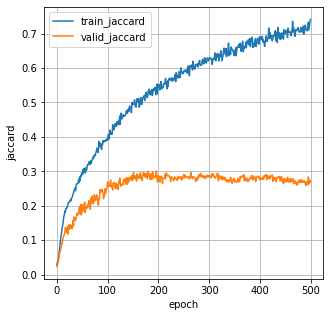

In [22]:
plt.figure(figsize=(5,5))
plt.plot(segm_asbest_dict['asb_iou'], label='train_jaccard')
plt.plot(segm_asbest_dict['val_asb_iou'], label='valid_jaccard')
plt.ylabel('jaccard')
plt.xlabel('epoch')
plt.legend()
plt.grid('on')
plt.savefig('graphics/jaccard_unet.png', bbox_inches='tight', pad_inches=None)

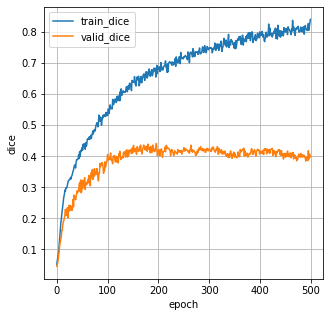

In [23]:
plt.figure(figsize=(5,5))
plt.plot(segm_asbest_dict['asb_dice'], label='train_dice')
plt.plot(segm_asbest_dict['val_asb_dice'], label='valid_dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend()
plt.grid('on')
plt.savefig('graphics/dice_unet.png', bbox_inches='tight', pad_inches=None)

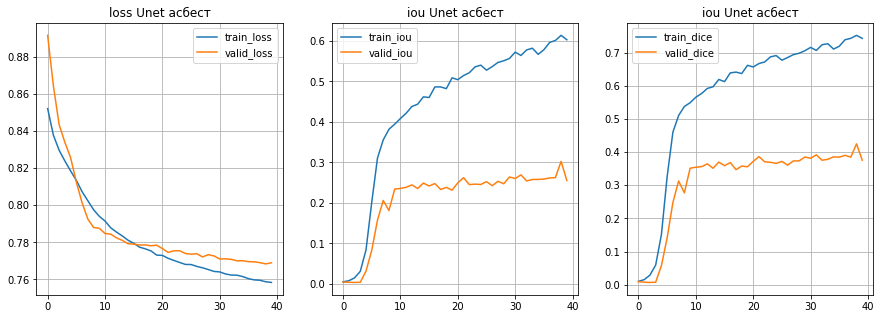

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('loss Unet асбест')
plt.plot(segm_asbest_dict['loss'], label='train_loss')
plt.plot(segm_asbest_dict['val_loss'], label='valid_loss')
plt.legend()
plt.grid('on')
plt.subplot(132)
plt.title('iou Unet асбест')
plt.plot(segm_asbest_dict['asb_iou'], label='train_iou')
plt.plot(segm_asbest_dict['val_asb_iou'], label='valid_iou')
plt.legend()
plt.grid('on')
plt.subplot(133)
plt.title('iou Unet асбест')
plt.plot(segm_asbest_dict['asb_dice'], label='train_dice')
plt.plot(segm_asbest_dict['val_asb_dice'], label='valid_dice')
plt.legend()
plt.grid('on')

In [18]:
torch.save(model.state_dict(), 'asbest_segmentation_b1_v1.0.pth')

In [ ]:
anno_stone = sum([anno_stone_161220, anno_lab_stone],[])

In [ ]:
from tqdm import trange, tqdm
from torch.utils.data import DataLoader
# anno = anno_tr_stones
model.load_state_dict(torch.load('asbest_segmentation_b0_v1.0.pth'))

# save_fig(crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), inp_size=img_sizes[0])

img_sizes = [(1024, 1024)]#, (3*224, 3*224), (4*224, 4*224)]
# crop_sizes = [
#               None,
#               None,
#               None,
#              ]
crop_sizes = [ (4*256, 4*256)
#               (int(img_stones_shape[0] // 2), int(img_stones_shape[1] // 3)), 
            #  (int(img_stones_shape[0] // 2), int(img_stones_shape[1] // 3)),
             # (int(img_stones_shape[0] // 2), int(img_stones_shape[1] // 3)),
             ]
num_frames = [(5*11, 5*2)] #, (400, 50), (400, 50)]
batches = [1]#, 4, 2]
num_epochs = [100]#, 100, 100]

for epochs, batch, crop_size, img_size, num_frame in zip(num_epochs, batches, crop_sizes, img_sizes, num_frames):

    tr_stones_train_data = Asbest_segmentation(imp_anno_tr_stones[:11], 
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = False,
                                            num_frames=num_frame[0], 
                                            normalize=True
                                           )
    tr_stones_valid_data = Asbest_segmentation(imp_anno_tr_stones[11:13],  
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = False,
                                            num_frames=num_frame[1], 
                                            normalize=True
                                           )
    
    stones_train_loader = DataLoader(tr_stones_train_data, batch_size=batch, shuffle=True, num_workers=2)
    stones_valid_loader = DataLoader(tr_stones_valid_data, batch_size=1, shuffle=False, num_workers=2)
    
#     tr_stones_train_data = Asbest_segmentation(anno_tr_stones[:-30], 
#                                                crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
#                                                img_size=img_size, 
#                                                num_frames=100, 
#                                                normalize=True)
#     tr_stones_valid_data = Asbest_segmentation(anno_tr_stones[-30:], 
#                                                crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), 
#                                                img_size=img_size, 
#                                                num_frames=30, 
#                                                normalize=True)

#     tr_stones_train_loader = DataLoader(tr_stones_train_data, batch_size=2, shuffle=True, num_workers=4)
#     tr_stones_valid_loader = DataLoader(tr_stones_valid_data, batch_size=2, shuffle=False, num_workers=2)
    
    segm_asb_dict = {'loss':[], 'val_loss':[], 'asb_iou':[], 'val_asb_iou':[], 'asb_dice':[], 'val_asb_dice':[]}
    
    with tqdm(total=len(stones_train_loader) + len(stones_valid_loader),# + len(tr_stones_train_loader) + len(tr_stones_valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' +  
              '| iou_asb: {postfix[2]:>2.4f} ' + 
              '| dice_asb: {postfix[3]:>2.4f} ' + 
              '| val_loss : {postfix[4]:>2.4f} ' + 
              '| val_iou_asb: {postfix[5]:>2.4f} ' + 
              '| val_dice_asb: {postfix[6]:>2.4f} '
              , 
              postfix=[0, 0, 0, 0, 0, 0, 0], desc = 'Training', leave=True) as t:
        for epoch in range(1,epochs+1):
            
            t.postfix[0] = epoch
            
            average_total_loss = AverageMeter()
            average_iou_asb = AverageMeter()
            average_dice_asb = AverageMeter()

            model.train()
            for data in stones_train_loader:

                torch.cuda.empty_cache()
                inputs, st_masks, asb_masks = data
                masks = torch.cat((st_masks, asb_masks), axis=1)

                inputs=inputs.to(device).float()
                masks=masks.to(device).float()

                optimizer.zero_grad()
                outputs = model(inputs)

                loss = 1.0 * bce(outputs[:,1:,:,:], masks[:,1:,:,:]) + 0.0 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])

#                 iou_stones = metrics[0](outputs[:,0:1,:,:], masks[:,0:1,:,:])
#                 fscore_stones = metrics[1](outputs[:,0:1,:,:], masks[:,0:1,:,:])
                iou_asb = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
                dice_asb = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])

                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                optimizer.step()

                average_total_loss.update(loss.data.item())
                average_iou_asb.update(iou_asb.data.item())
                average_dice_asb.update(dice_asb.data.item())

                t.postfix[1] = average_total_loss.average()
                t.postfix[2] = average_iou_asb.average()
                t.postfix[3] = average_dice_asb.average()
                t.update()
            
        
            ## Validation          
            val_average_total_loss = AverageMeter()
            val_average_iou_asb = AverageMeter()
            val_average_dice_asb = AverageMeter()


            model.eval()
            torch.cuda.empty_cache()
            for data in stones_valid_loader:

#                 
                inputs, st_masks, asb_masks = data
                masks = torch.cat((st_masks, asb_masks), axis=1)

                inputs=inputs.to(device).float()
                masks=masks.to(device).float()

                outputs = model(inputs)

                loss = 1.0 * bce(outputs[:,1:,:,:], masks[:,1:,:,:]) + 0.0 * dice(outputs[:,1:,:,:], masks[:,1:,:,:])

                iou_asb = metrics[0](outputs[:,1:,:,:], masks[:,1:,:,:])
                dice_asb = metrics[1](outputs[:,1:,:,:], masks[:,1:,:,:])

                val_average_total_loss.update(loss.data.item())
                val_average_iou_asb.update(iou_asb.data.item())
                val_average_dice_asb.update(dice_asb.data.item())

                t.postfix[4] = val_average_total_loss.average()
                t.postfix[5] = val_average_iou_asb.average()
                t.postfix[6] = val_average_dice_asb.average()
                t.update()
            
            segm_asb_dict['loss'].append(average_total_loss.average())
            segm_asb_dict['val_loss'].append(val_average_total_loss.average())
            segm_asb_dict['asb_iou'].append(average_iou_asb.average())
            segm_asb_dict['val_asb_iou'].append(val_average_iou_asb.average())
            segm_asb_dict['asb_dice'].append(average_dice_asb.average())
            segm_asb_dict['val_asb_dice'].append(val_average_dice_asb.average())
            
            if epoch % 10 == 0:
                save_fig(crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), inp_size=img_size)
            
#             if epoch == 1 or epoch % 5 == 0:
#                 save_fig(crop_size=(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), inp_size=img_sizes[0])

#                 manual_results = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}
#                 net_results = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}

#                 for it in anno_tr_stones:
#                     name = it['name'].split('/')[-1]
#                     if get_time(name).day != 16:
#                         continue
#                     probe = int(name.split('_')[0])
#                     if probe < 10 or probe > 14:
#                         continue
#                     st_mask = create_mask_file(it, 'stone', binary=True)
#                     asb_mask = create_mask_file(it, 'asbest', binary=True)
#                     manual_results['probes'].append(probe)
#                     manual_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
#                     manual_results['asbest'].append(np.sum(asb_mask))
#                     manual_results['stones'].append(np.sum(st_mask))
#                     manual_results['trues'].append(true_results[16][probe])

#                 for it in anno_tr_stones:
#                     name = it['name'].split('/')[-1]
#                     if get_time(name).day != 16:
#                         continue
#                     probe = int(name.split('_')[0])
#                     if probe < 10 or probe > 14:
#                         continue
#         #                     probe = int(name.split('_')[0])
#                     img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
#                     _, _, asb_mask = big_image_predict(model, 
#                                                       img, 
#                                                       crop_size=(img.shape[0] // 2, img.shape[1] // 2),
#                                                       inp_size=img_size,
#                                                       device=device
#                                                      )
#                     st_mask = create_mask_file(it, 'stone', binary=True)
#                     asb_mask = asb_mask > 0.5
#                 #     asb_mask = create_mask_file(it, 'asbest')
#                     net_results['probes'].append(probe)
#                     net_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
#                     net_results['asbest'].append(np.sum(asb_mask))
#                     net_results['stones'].append(np.sum(st_mask))
#                     net_results['trues'].append(true_results[16][probe])

# #                 p_manual = np.polyfit(manual_results['preds'], manual_results['trues'], 1)
# #                 reg_manual = np.polyval(p_manual, [min(manual_results['preds']), max(manual_results['preds'])])

# #                 p_net = np.polyfit(net_results['preds'], net_results['trues'], 1)
# #                 reg_net = np.polyval(p_net, [min(net_results['preds']), max(net_results['preds'])])

# #                 plt.figure(figsize=(12,6))
# #                 plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
# #                 plt.plot([min(manual_results['preds']), max(manual_results['preds'])], reg_manual, 'b')

# #                 plt.scatter(net_results['preds'], net_results['trues'], c='r')
# #                 plt.plot([min(net_results['preds']), max(net_results['preds'])], reg_net, 'r')
# #                 plt.savefig('graphics/' + datetime.now().strftime("%H:%M:%S") + '_points.png', dpi=100)
            
            t.reset()

0.7228783737529408 0.7173517942428589 0.6510430392301219 0.5581180959939956 0.7473435512405228 0.7107382833957672


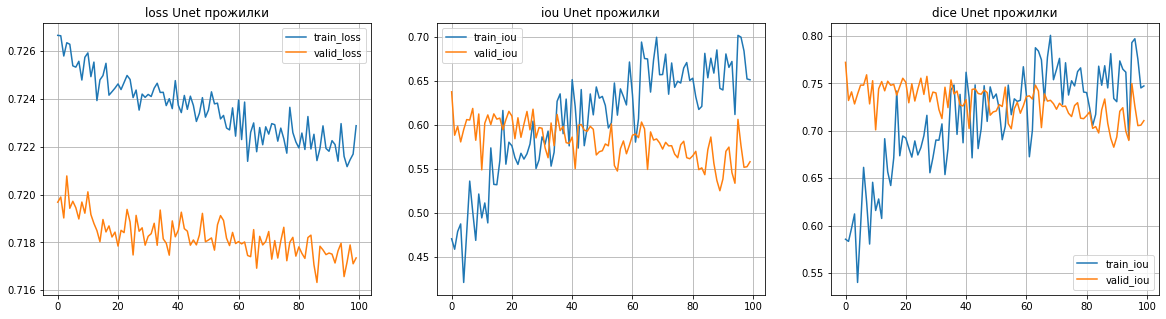

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('loss Unet прожилки')
plt.plot(segm_asb_dict['loss'], label='train_loss')
plt.plot(segm_asb_dict['val_loss'], label='valid_loss')
plt.legend()
plt.grid('on')
plt.subplot(132)
plt.title('iou Unet прожилки')
plt.plot(segm_asb_dict['asb_iou'], label='train_iou')
plt.plot(segm_asb_dict['val_asb_iou'], label='valid_iou')
plt.legend()
plt.grid('on')
plt.subplot(133)
plt.title('dice Unet прожилки')
plt.plot(segm_asb_dict['asb_dice'], label='train_iou')
plt.plot(segm_asb_dict['val_asb_dice'], label='valid_iou')
plt.legend()
plt.grid('on')
print(segm_asb_dict['loss'][-1], segm_asb_dict['val_loss'][-1], segm_asb_dict['asb_iou'][-1], segm_asb_dict['val_asb_iou'][-1], segm_asb_dict['asb_dice'][-1], segm_asb_dict['val_asb_dice'][-1])

In [22]:
tr_stones_test_data = Asbest_segmentation(imp_anno_tr_stones[13:],  
                                            crop_size=crop_sizes[0], 
                                            img_size=img_sizes[0],
                                            load_in_ram = False,
                                            num_frames=num_frame[1], 
                                            normalize=True
                                           )
tr_stones_test_loader = DataLoader(tr_stones_test_data, batch_size=1, shuffle=False, num_workers=2)

model.eval()

test_average_total_loss = AverageMeter()
test_average_asb_iou = AverageMeter()
test_average_asb_dice = AverageMeter()

for data in tr_stones_test_loader:

    torch.cuda.empty_cache()
    inputs, st_masks, asb_masks = data

    inputs=inputs.to(device).float()
    st_masks=st_masks.to(device).float()
    asb_masks=asb_masks.to(device).float()

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = 0.5 * bce(outputs[:,1:2,:,:], asb_masks) + 0.5 * dice(outputs[:,1:2,:,:], asb_masks) + 0.0 * dice(outputs[:,1:2,:,:], asb_masks)
    asb_iou = metrics[0](outputs[:,1:2,:,:], asb_masks)
    asb_dice = metrics[1](outputs[:,1:2,:,:], asb_masks)

    test_average_total_loss.update(loss.data.item())
    test_average_asb_iou.update(asb_iou.data.item())
    test_average_asb_dice.update(asb_dice.data.item())
    
print(test_average_total_loss.average(), test_average_asb_iou.average(), test_average_asb_dice.average())

0.7251676797866822 0.4670955688809045 0.6047894717310556


In [32]:
tr_stones_test_data = Asbest_segmentation(imp_anno_tr_stones[20:], 
                                           crop_size=crop_size,#(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2), 
                                           img_size=img_size, 
                                           num_frames=14*5, 
                                           normalize=True)
tr_stones_test_loader = DataLoader(tr_stones_test_data, batch_size=1, shuffle=False, num_workers=2)

model.eval()

test_average_total_loss = AverageMeter()
test_average_asb_iou = AverageMeter()
test_average_asb_dice = AverageMeter()

for data in tr_stones_test_loader:

    torch.cuda.empty_cache()
    inputs, st_masks, asb_masks = data

    inputs=inputs.to(device).float()
    st_masks=st_masks.to(device).float()
    asb_masks=asb_masks.to(device).float()

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = 0.5 * bce(outputs[:,1:2,:,:], asb_masks) + 0.5 * dice(outputs[:,1:2,:,:], asb_masks) + 0.0 * dice(outputs[:,1:2,:,:], asb_masks)
    asb_iou = metrics[0](outputs[:,1:2,:,:], asb_masks)
    asb_dice = metrics[1](outputs[:,1:2,:,:], asb_masks)

    test_average_total_loss.update(loss.data.item())
    test_average_asb_iou.update(asb_iou.data.item())
    test_average_asb_dice.update(asb_dice.data.item())
    
print(test_average_total_loss.average(), test_average_asb_iou.average(), test_average_asb_dice.average())

0.7744175502232142 0.12487470211718964 0.2061925266150086


In [23]:
torch.save(model.state_dict(), 'asbest_segmentation_b3_v1.2.pth')

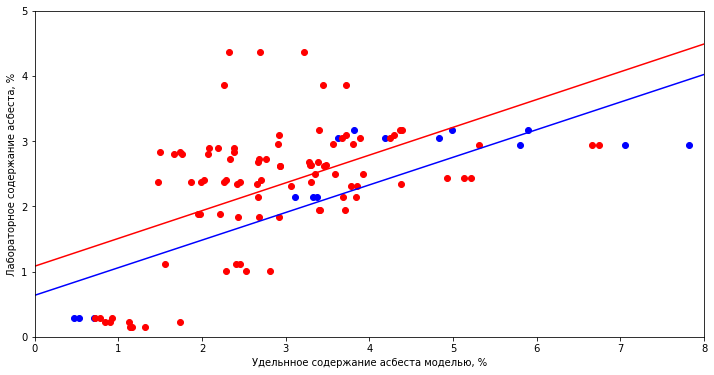

In [35]:
save_fig(crop_size=img_sizes[0], inp_size=img_sizes[0])
            
manual_results = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}
net_results = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}

for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 14:
        continue
    st_mask = create_mask_file(it, 'stone', binary=True)
    asb_mask = create_mask_file(it, 'asbest', binary=True)
    manual_results['probes'].append(probe)
    manual_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    manual_results['asbest'].append(np.sum(asb_mask))
    manual_results['stones'].append(np.sum(st_mask))
    manual_results['trues'].append(true_results[16][probe])

for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
#     if probe < 10 or probe > 14:
#         continue
#                     probe = int(name.split('_')[0])
    img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
    _, _, asb_mask = big_image_predict(model, 
                                      img, 
                                      crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                      inp_size=img_size,
                                      device=device
                                     )
    st_mask = create_mask_file(it, 'stone', binary=True)
    asb_mask = asb_mask > 0.5
#     asb_mask = create_mask_file(it, 'asbest')
    net_results['probes'].append(probe)
    net_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    net_results['asbest'].append(np.sum(asb_mask))
    net_results['stones'].append(np.sum(st_mask))
    net_results['trues'].append(true_results[16][probe])

p_manual = np.polyfit(manual_results['preds'], manual_results['trues'], 1)
reg_manual = np.polyval(p_manual, [0, 10])

p_net = np.polyfit(net_results['preds'], net_results['trues'], 1)
reg_net = np.polyval(p_net, [0, 10])

plt.figure(figsize=(12,6))
plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
plt.plot([0, 10], reg_manual, 'b')

plt.scatter(net_results['preds'], net_results['trues'], c='r')
plt.plot([0, 10], reg_net, 'r')
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста моделью, %')
plt.ylabel('Лабораторное содержание асбеста, %')
plt.savefig('graphics/' + datetime.now().strftime("%H:%M:%S") + '_points.png', dpi=100)

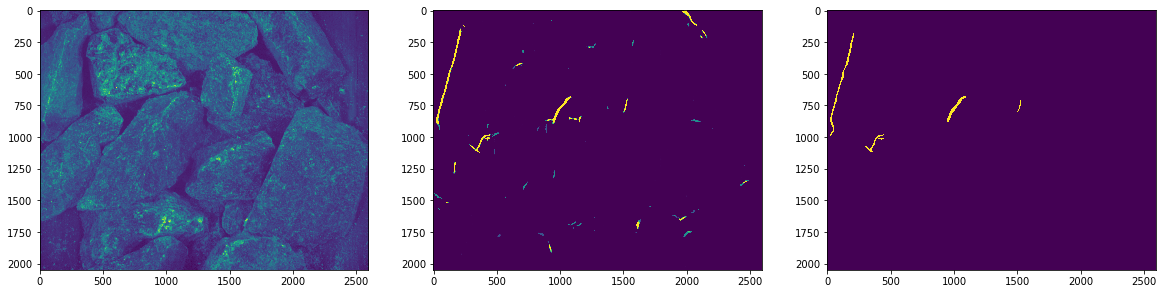

In [17]:
img_size = (2*448, 2*448)
k = []
for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 10:
        continue
    img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
    _, _, asb_pred = big_image_predict(model, 
                                      img, 
                                      crop_size=img_size,#(img.shape[0] // 2, img.shape[1] // 2),
                                      inp_size=img_size,
                                      device=device
                                     )
    asb_manual = create_mask_file(it, 'asbest')
    k.append(np.sum(asb_manual)  / np.sum(asb_pred))
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(asb_pred)
plt.subplot(133)
plt.imshow(asb_manual)

In [18]:
k

[0.7557381968273755, 0.5792205538009214, 0.5130879106017624]

In [17]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/22_13:21:36_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/20_12:23:59_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
image, mask = big_image_predict(model, img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (2*448,2*448), device=device)
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(image)
plt.subplot(133)
plt.imshow(mask)

ValueError: too many values to unpack (expected 2)

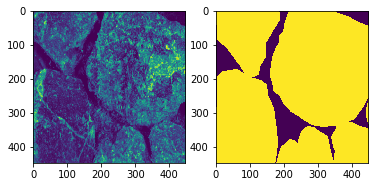

In [7]:
index = 73
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.stone_masks[index])

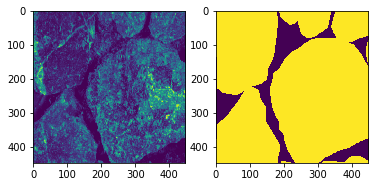

In [8]:
index = 31
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.stone_masks[index])

In [10]:
from torch import nn
from torch import sigmoid
import segmentation_models_pytorch as smp


device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, activation='sigmoid').to(device)

bce = smp.utils.losses.BCEWithLogitsLoss()
dice = smp.utils.losses.DiceLoss(activation='sigmoid')
# criterion = nn.CrossEntropyLoss()
# criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc


metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 

    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])

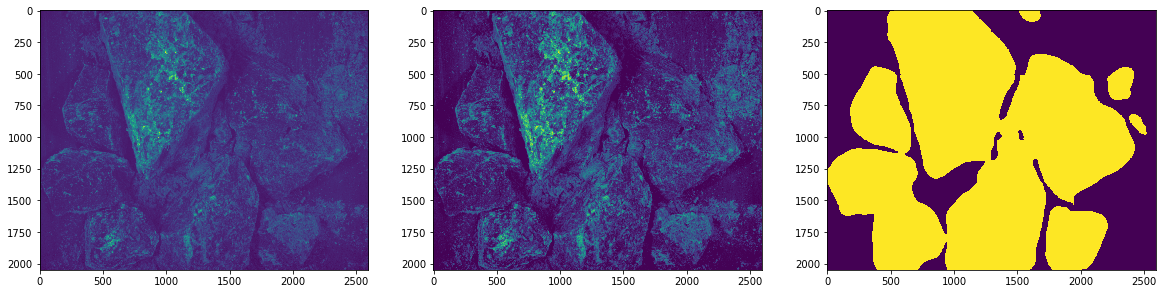

In [16]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
image, mask = big_image_predict(model, img, crop_size = (img.shape[1] // 2, img.shape[0] // 2), inp_size = (448,448), device=device)
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(image)
plt.subplot(133)
plt.imshow(mask > 0.95)

In [17]:
train_data = Asbest_segmentation(anno[:-5], crop_size=(img_shape[0] // 4, img_shape[1] // 4), img_size=(448, 448), num_frames=1000, normalize=True)
valid_data = Asbest_segmentation(anno[-5:], crop_size=(img_shape[0] // 4, img_shape[1] // 4), img_size=(448, 448), num_frames=200, normalize=True)

100%|██████████| 200/200 [00:23<00:00,  8.69it/s]


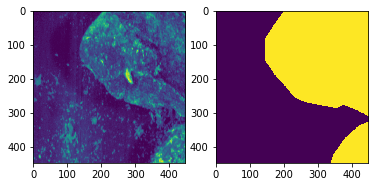

In [19]:
index = 73
plt.subplot(121)
plt.imshow(train_data.images[index])
plt.subplot(122)
plt.imshow(train_data.stone_masks[index])

In [20]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True, num_workers=2)

In [21]:
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-5}, 

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [29]:
from tqdm import trange, tqdm

epochs = 5

for epoch in range(epochs):
    
    average_total_loss = AverageMeter()
    average_acc = AverageMeter()
    average_iou = AverageMeter()
    average_fscore = AverageMeter()
    average_total_val_loss = AverageMeter()
    average_val_acc = AverageMeter()
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            loss.backward()
            optimizer.step()

            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            average_iou.update(iou.data.item())
            average_fscore.update(fscore.data.item())
            
            t.postfix[1] = average_total_loss.average()
            t.postfix[2] = average_acc.average()
            t.postfix[3] = average_iou.average()
            t.postfix[4] = average_fscore.average()
            t.update()

    ## Validation
    val_average_total_loss = AverageMeter()
    val_average_acc = AverageMeter()
    val_average_iou = AverageMeter()
    val_average_fscore = AverageMeter()
    val_average_total_val_loss = AverageMeter()
    val_average_val_acc = AverageMeter()
    
    model.train(False)
    with tqdm(total=len(valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Validation') as t:
        t.postfix[0] = epoch + 1
        for data in valid_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = 0.7 * bce(outputs, masks) + 0.3 * dice(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            loss.backward()
            optimizer.step()

            val_average_total_loss.update(loss.data.item())
            val_average_acc.update(acc.data.item())
            val_average_iou.update(iou.data.item())
            val_average_fscore.update(fscore.data.item())
            
            t.postfix[1] = val_average_total_loss.average()
            t.postfix[2] = val_average_acc.average()
            t.postfix[3] = val_average_iou.average()
            t.postfix[4] = val_average_fscore.average()
            t.update()
#     model.train(False)
#     mask = predict(model, image)
#     mask = cv2.resize(mask, (1042, 719))
#     images = np.concatenate((cv2.cvtColor(cv2.resize(image, (1042, 719)), cv2.COLOR_RGB2GRAY), 255*mask), axis=1)
# #     images = cv2.resize(images, (1024, 1680))
#     cv2.imwrite(os.path.join('result', 'train.bmp'), images)
    
#     mask = predict(model, val_image)
#     mask = cv2.resize(mask, (1042, 719))
#     images = np.concatenate((cv2.cvtColor(cv2.resize(val_image, (1042, 719)), cv2.COLOR_RGB2GRAY), 255*mask), axis=1)
# #     images = np.concatenate((cv2.cvtColor(val_image, cv2.COLOR_RGB2GRAY), 255*(mask > threshold)), axis=1)
# #     images = cv2.resize(images, (1024, 1680))
#     cv2.imwrite(os.path.join('result', 'valid.bmp'), images)

Training epoch 1 | 125/125 01:16<00:00 | loss : 0.4299 | acc : 2.6585 | iou: 0.9157 | fscore: 0.9549
Validation epoch 1 | 25/25 00:15<00:00 | loss : 0.4250 | acc : 3.0736 | iou: 0.9487 | fscore: 0.9736
Training epoch 2 | 125/125 01:16<00:00 | loss : 0.4267 | acc : 2.6585 | iou: 0.9256 | fscore: 0.9609
Validation epoch 2 | 25/25 00:15<00:00 | loss : 0.4236 | acc : 3.0736 | iou: 0.9515 | fscore: 0.9751
Training epoch 3 | 125/125 01:16<00:00 | loss : 0.4262 | acc : 2.6585 | iou: 0.9270 | fscore: 0.9618
Validation epoch 3 | 25/25 00:15<00:00 | loss : 0.4240 | acc : 3.0736 | iou: 0.9506 | fscore: 0.9746
Training epoch 4 | 125/125 01:16<00:00 | loss : 0.4246 | acc : 2.6585 | iou: 0.9319 | fscore: 0.9644
Validation epoch 4 | 25/25 00:15<00:00 | loss : 0.4223 | acc : 3.0736 | iou: 0.9539 | fscore: 0.9764
Training epoch 5 | 125/125 01:16<00:00 | loss : 0.4245 | acc : 2.6585 | iou: 0.9336 | fscore: 0.9654
Validation epoch 5 | 25/25 00:15<00:00 | loss : 0.4225 | acc : 3.0736 | iou: 0.9542 | fscor

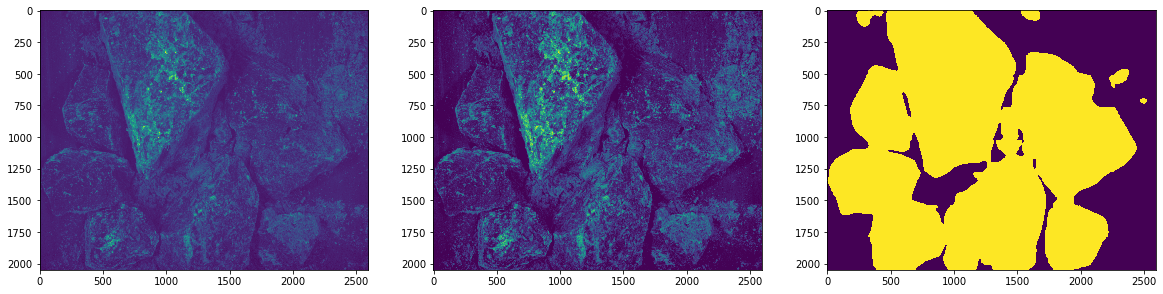

In [30]:
img = cv2.imread('asbest/tr_stones/9_12:40:22_05-03-2020_1.png', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
image, mask = big_image_predict(model, img, crop_size = (img.shape[1] // 4, img.shape[0] // 4), inp_size = (448,448), device=device)
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(image)
plt.subplot(133)
plt.imshow(mask > 0.95)

In [5]:
model_load = torch.load('stone_segmentation.pth');
model_load.eval();

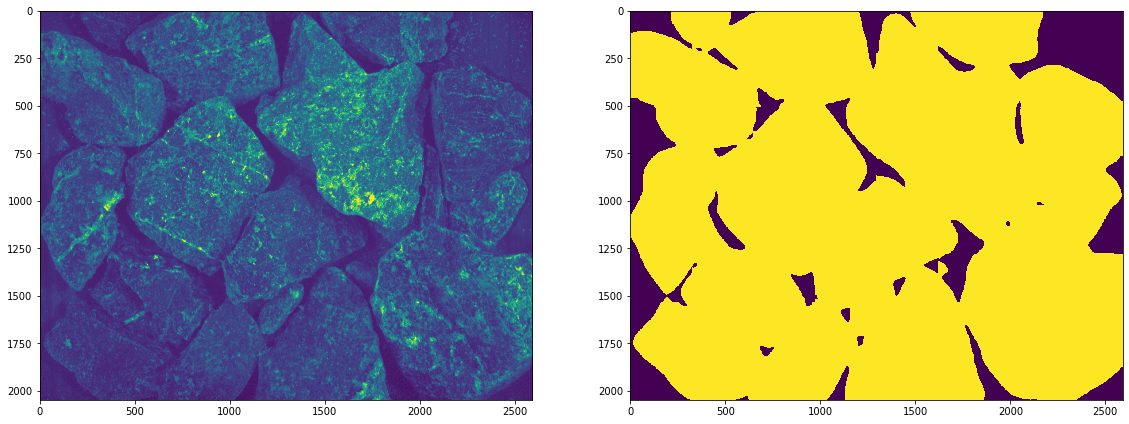

In [13]:
path_img = 'asbest/tr_stones/13_12:04:15_16-03-2020_1.png'
img = cv2.imread(path_img, cv2.IMREAD_UNCHANGED)
# img = cv2.imread('asbest/tr_stones/1_11:32:12_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
mask = big_image_predict(model_load, img, crop_size = (img.shape[1] // 4, img.shape[0] // 4), inp_size = (224,224))
plt.figure(figsize=(30,15))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(np.clip(mask, 0, 1) > 0.5)
plt.savefig(path_img.split('/')[-1].split('_')[0] + '.png', dpi=100, bbox_inches='tight', pad_inches=0)